<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning_practice/blob/main/HW_19_sec2sec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добро пожаловать на задание уровня Pro.
Необходимо написать чат-бота, используя модель seq2seq.

Ссылка на базу https://storage.yandexcloud.net/aiueducation/Content/advanced/l3/9kdialogs.txt

База содержит примеры пар: вопрос-ответ. По аналогии с моделью преводчика (англ - рус), создайте чат-бота (вопрос - ответ)

In [ ]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

import gdown

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l3/9kdialogs.txt', None, quiet=True)

'9kdialogs.txt'

In [ ]:
with open("9kdialogs.txt", 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines = f.read().split('\n')                 # Читаем весь файл, режем на строки

# Цикл по строкам
lines_copy = lines.copy()
for i,line in enumerate(lines):
    if line == '':
      lines_copy.remove(line)

In [ ]:
print(len(lines_copy))

19828


In [ ]:
#print(questions[0].replace('- - ', ''))

﻿Как вы можете быть таким уверенным?


In [ ]:
def my_replacer(s):  

    ''' Функция для удаления пробелов перед знаками препинания

        Args: строка или список строк

        Returns: строка или список строк
    '''

    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?').replace('- - ', '').strip(' - -').strip('- - ').strip('-').strip('- -').lower()

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?').replace('- - ', '').strip(' - -').strip('- - ').strip('-').strip('- -').lower()) # Убираем перед знаками препинания пробел и возвращаем

        # Вернем список строк
        return ou    

In [ ]:
questions = [] # Переменная для списка входных фраз
answers = []   # Переменная для списка ответных фраз                              
for i in range(0, len(lines_copy), 2):
  try:
      questions.append(my_replacer(lines_copy[i]))
      answers.append(my_replacer(lines_copy[i+1]))
  except:
      continue                                    

In [ ]:
# Добавим в каждую ответную фразу теги  <START> и <END>
answers = ['<START> ' + s + ' <END>' for s in answers]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[111])) # Пример входной фразы
print('Ответ : {}'.format(answers[111]))    # Пример ответной фразы

Вопрос : больно?
Ответ : <START> немного. <END>


In [ ]:
for i in range(0,10):
  print(i, questions[i], answers[i])

0 ﻿как вы можете быть таким уверенным? <START> элементарно. <END>
1 а что делать будем? <START> ждать. <END>
2 надеюсь, не до первой звезды? <START> я тоже на это надеюсь. <END>
3 за что? <START> вы знаете за что! <END>
4 ты что-нибудь понимаешь? <START> абсолютно ничего. <END>
5 обсудим это завтра, ладно? <START> хорошо. <END>
6 кто услышит? <START> кто-кто..ну твой следователь. <END>
7 что - если? <START> так, ничего. <END>
8 ну я пойду? <START> а? иди, иди. постой... <END>
9 может, стоило ее предупредить? <START> может. <END>


In [ ]:
len(questions) == len(answers)

True

In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(oov_token='unknown', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ') 

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions + answers)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))         

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('что', 4), ('не', 5), ('ты', 6), ('а', 7), ('я', 8), ('в', 9), ('да', 10), ('это', 11), ('вы', 12), ('как', 13), ('нет', 14), ('и', 15), ('ну', 16), ('где', 17), ('на', 18), ('у', 19), ('с', 20), ('кто', 21), ('так', 22), ('же', 23), ('он', 24), ('то', 25), ('все', 26), ('мне', 27), ('куда', 28), ('чего', 29), ('там', 30), ('меня', 31), ('есть', 32), ('тебя', 33), ('вас', 34), ('за', 35), ('тебе', 36), ('еще', 37), ('знаю', 38), ('вам', 39), ('мы', 40), ('почему', 41), ('ничего', 42), ('здесь', 43), ('может', 44), ('она', 45), ('конечно', 46), ('можно', 47), ('чем', 48), ('его', 49), ('зачем', 50)]
Размер словаря : 11408


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Уточняем длину самой длинной фразы
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput = np.array(paddedQuestions)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions[10]))         
print('Пример кодированной входной фразу            : {}'.format(encoderForInput[10]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions))        

Пример входной фразы                         : а вы тут, что ли, не одна живете?
Пример кодированной входной фразу            : [  7  12  60   4  53   5 264 946   0   0   0]
Размеры закодированного массива входных фраз : (9914, 11)
Установленная длина входных фраз             : 11


In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

# Уточняем длину самого длинного ответа
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput = np.array(paddedAnswers)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))        

Пример оригинального ответа на вход: <START> да, вроде, ничего особенного. <END>
Пример кодированного ответа на вход : [  2  10 172  42 481   3   0   0   0   0   0   0   0   0]
Размеры кодированного массива ответов на вход : (9914, 14)
Установленная длина ответов на вход : 14


In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

for i in range(len(tokenizedAnswers)) :                  # Для разбитых на последовательности ответов
    tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)     

In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers))                    

Пример кодированного ответа на вход : [  2  10 172  42 481   3   0   0   0   0   0   0   0   0]
Пример кодированного ответа на выход : [ 10 172  42 481   3   0   0   0   0   0   0   0   0   0]
Размеры кодированного массива ответов на выход : (9914, 14)
Установленная длина вопросов на выход : 14


In [ ]:
# Создадим энкодер 

encoderInputs = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)  # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding) # Добавим LSTM
encoderStates = [state_h, state_c]                                                 # Соберем выходы lstm  в список    

In [ ]:
# Создадим декодер 

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense (decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
# Собираем модель

model = Model([encoderInputs, decoderInputs], output)

In [ ]:
# Компилиуем модель

model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

In [ ]:
# Выведем на экран информацию о построенной модели нейросети

print(model.summary())  

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 200)    2281600     ['input_7[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, None, 200)    2281600     ['input_8[0][0]']                
                                                                                            

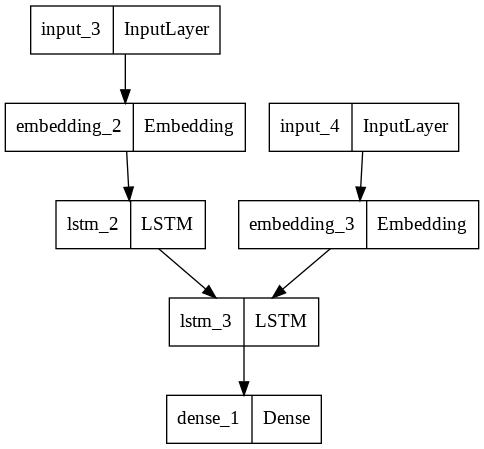

In [ ]:
# Построим график для визуализации слоев и связей между ними

plot_model(model, to_file='model.png')

Пора обучаться. И не забудем сохранить обученную модель на диске

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=256, epochs=30) 

# Сохраним модель на диске
model.save( 'content/model_30epochs(rms).h5' )

Epoch 1/30
39/39 [==============================] - 1s 29ms/step - loss: 0.5652
Epoch 2/30
39/39 [==============================] - 1s 29ms/step - loss: 0.5506
Epoch 3/30
39/39 [==============================] - 1s 29ms/step - loss: 0.5358
Epoch 4/30
39/39 [==============================] - 1s 29ms/step - loss: 0.5213
Epoch 5/30
39/39 [==============================] - 1s 29ms/step - loss: 0.5064
Epoch 6/30
39/39 [==============================] - 1s 29ms/step - loss: 0.4924
Epoch 7/30
39/39 [==============================] - 1s 29ms/step - loss: 0.4785
Epoch 8/30
39/39 [==============================] - 1s 29ms/step - loss: 0.4650
Epoch 9/30
39/39 [==============================] - 1s 29ms/step - loss: 0.4517
Epoch 10/30
39/39 [==============================] - 1s 29ms/step - loss: 0.4375
Epoch 11/30
39/39 [==============================] - 1s 29ms/step - loss: 0.4259
Epoch 12/30
39/39 [==============================] - 1s 28ms/step - loss: 0.4121
Epoch 13/30
39/39 [==================

In [ ]:
# Сохраним веса модели
model.save_weights('s2s_30epochs.h5')

In [ ]:
def makeInferenceModels():

    ''' Функция сборки сети для перевода фраз из уже обученных слов

        Args: -

        Returns: модели энкодера и декодера   
    '''    

    # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
    encoderModel = Model(encoderInputs, encoderStates) 

    # Создадим модель декодера
    decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
    decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

    # Соберем оба inputs вместе и запишем в decoderStatesInputs
    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

    # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
    decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) 
    
    # LSTM даст нам новые состояния
    decoderStates = [state_h, state_c]            
    
    # И ответы, которые мы пропустим через полносвязный слой с софтмаксом
    decoderOutputs = decoderDense(decoderOutputs) 

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

    # Вернем рабочие модели энкодера и декодера  
    return encoderModel , decoderModel

In [ ]:
def strToTokens(sentence: str):      

    ''' Функция для удаления пробелов перед знаками препинания

        Args: фраза

        Returns: список токенов
    '''

    # Почистим фразу
    tmp_sent = my_replacer(sentence)  
    
    # Приведем предложение к нижнему регистру и разбирает на слова
    words = tmp_sent.lower().split()  
    
    # Создадим список для последовательности токенов/индексов
    tokensList = list()               

    # Для каждого слова в предложении
    for word in words:
        
        try:
            tokensList.append(tokenizer.word_index[word]) # Определяем токенайзером индекс и добавляем в список
        except:
            pass # Слова нет - просто игнорируем его

    # Вернёт входную фразу в виде последовательности индексов
    if tokensList:
        return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

    # Фраза из незнакомых слов - вернем None 
    return None

Запускаем функцию для построения модели кодера и декодера

In [ ]:
encModel , decModel = makeInferenceModels() 

In [ ]:
# Цикл по количеству входных фраз - их 6

for _ in range(6):

    # подготовка
    
    qua  = strToTokens(input('Задайте мне вопрос: '))
    if qua is None:                                      
        print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
        continue                                             # Пойдем за следущей фразой

    emptyTargetSeq = np.zeros((1, 1))                    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 
    stopCondition = False                                
    decodedTranslation = '' 
    statesValues = encModel.predict(qua)                              

    # пока не сработало стоп-условие
    while not stopCondition:                             

        # В модель декодера подадим пустую последовательность со словом 'start' и состояния
        decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
        # Получим индекс предсказанного слова.
        sampledWordIndex = np.argmax( decOutputs[0, 0, :]) 
        # Создаем переменную для преобразованных на естественный язык слов
        sampledWord = None                                 

        # Переберем в цикле все индексы токенайзера
        for word, index in tokenizer.word_index.items():
        
            # Если индекс выбранного слова соответствует какому-то индексу из словаря
            if sampledWordIndex == index:              
                # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
                decodedTranslation += ' {}'.format(word) 
                # Выбранное слово фиксируем в переменную sampledWord
                sampledWord = word                       
        
        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
        if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
            stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

        # Создаем пустой массив
        emptyTargetSeq = np.zeros((1, 1))       
        
        # Заносим в него индекс выбранного слова
        emptyTargetSeq[0, 0] = sampledWordIndex 
        
        # Записываем состояния, обновленные декодером 
        statesValues = [h, c]   

        # И продолжаем цикл с обновленными параметрами                
                                                
    # Выводим ответ сгенерированный декодером
    print("Ответ: ", decodedTranslation[:-4]) 

Задайте мне вопрос: кто ты
Ответ:   я
Задайте мне вопрос: почему ты съел курицу
Ответ:   покориться судьбе
Задайте мне вопрос: какой поезд завтра
Ответ:   когда
Задайте мне вопрос: есть места?
Ответ:   а кто
Задайте мне вопрос: пойдем гулять?
Ответ:   ну
Задайте мне вопрос: какая погода сегодня?
Ответ:   не знаю
